In [14]:
import os 
import pytorch_lightning as pl
import seml
import numpy as np
import torch

import scanpy as sc
import scvelo as scv
import cellrank as cr
import pandas as pd

from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.models.base.vae import AE, VAE
from scvi.distributions import NegativeBinomial

import yaml

import sys 
sys.path.insert(0, "../../../" )
from paths import EXPERIMENT_FOLDER

In [15]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad', 
            'x_layer': 'X_norm', 
            'cond_key': 'experimental_time', 
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [0.8, 0.2],
            'batch_size': 256, 'num_workers': 2}

model_config = {'likelihood': 'nb', 
                  'dropout': False, 
                  'dropout_p': False, 
                  'hidden_dims': [512, 256, 64], 
                  'batch_norm': False, 
                  'model_log_library_size': True, 
               }

In [16]:
# Initialize datamodule
datamodule = scDataModule(**datamodule)



# Initialize the model 
model = AE(in_dim = datamodule.in_dim,
            **model_config) 

In [17]:
model.load_state_dict(torch.load("/nfs/homedirs/pala/scCFM/notebooks/train_autoencoder/eb/models_ae/model_lib.ckpt")["state_dict"])

<All keys matched successfully>

In [18]:
adata = sc.read_h5ad("/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad")

In [19]:
X_latents = []
library_sizes = []

model.eval()
for obs in adata.layers["X_norm"]:
    with torch.no_grad():
        t_obs = torch.from_numpy(obs.A).float()
        library_sizes.append(t_obs.sum(1).item())
        z = model.encode(t_obs)["z"]
        X_latents.append(z)

X_latents = torch.cat(X_latents, dim=0)
adata.obs["library_sizes"] = library_sizes

In [20]:
adata_latents = sc.AnnData(X=X_latents.numpy(), 
                              obs=adata.obs)

adata_latents.layers["X_latents"] = adata_latents.X.copy()

In [21]:
sc.tl.pca(adata_latents)
sc.pp.neighbors(adata_latents)
sc.tl.umap(adata_latents)

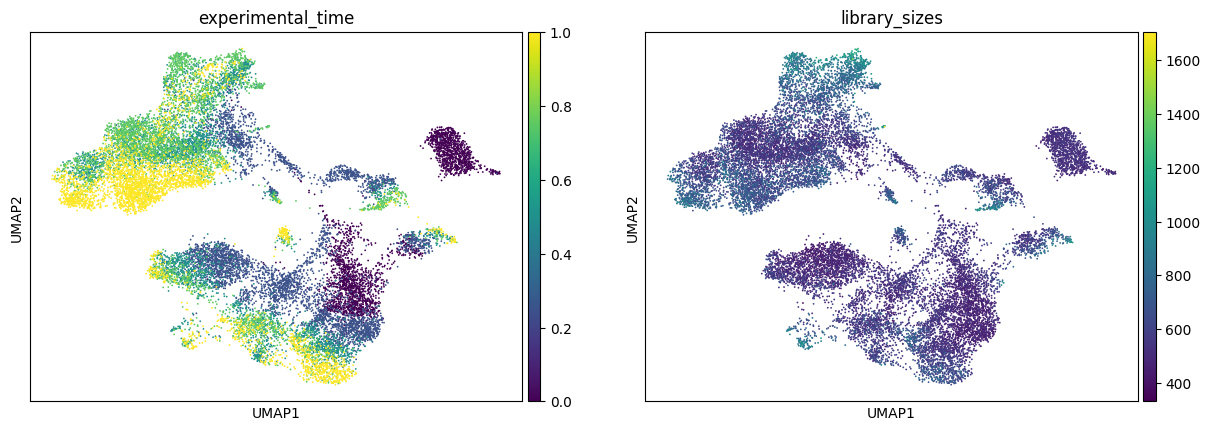

In [22]:
sc.pl.umap(adata_latents, color=["experimental_time", "library_sizes"])

In [24]:
adata_latents.write("/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate_latents.h5ad")